## Import Packages

In [2]:
# torch 
import torch
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
# read file
import os.path as osp
import os
# read & show images
import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
# random choose
import numpy as np
from numpy import random
from numpy.random import uniform
from random import shuffle
# others
import time
import math
import argparse
import warnings
import copy
warnings.filterwarnings("ignore")

## The MTCNN Model

In [7]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)


class P_Net(nn.Module):
    def __init__(self):
        super(P_Net, self).__init__()
        self.pre_layer = nn.Sequential(            
            nn.Conv2d(3, 10, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # PReLU1            
            nn.MaxPool2d(kernel_size=2, stride=2),            
            nn.Conv2d(10, 16, kernel_size=3, stride=1),             
            nn.PReLU(),  
            nn.Conv2d(16, 32, kernel_size=3, stride=1),  
            nn.PReLU()  
        )
       
        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1)        
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)        
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1)       
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        det = torch.sigmoid(self.conv4_1(x))
        box = self.conv4_2(x)
        landmark = self.conv4_3(x)
        # det:[,2,1,1], box:[,4,1,1], landmark:[,10,1,1]
        return det, box, landmark
    
class R_Net(nn.Module):
    def __init__(self):
        super(R_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            # 24x24x3
            nn.Conv2d(3, 28, kernel_size=3, stride=1),  # conv1
            nn.PReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.Conv2d(28, 48, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.Conv2d(48, 64, kernel_size=2, stride=1),
            nn.PReLU()  # prelu3
        )
        # 2x2x64
        self.conv4 = nn.Linear(64 * 2 * 2, 128)   # 128
        self.prelu4 = nn.PReLU() 
        self.conv5_1 = nn.Linear(128, 1)
        self.conv5_2 = nn.Linear(128, 4)
        self.conv5_3 = nn.Linear(128, 10)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv4(x)
        x = self.prelu4(x)
        det = torch.sigmoid(self.conv5_1(x))
        box = self.conv5_2(x)
        landmark = self.conv5_3(x)
        return det, box, landmark
    
class O_Net(nn.Module):
    def __init__(self):
        super(O_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=2, stride=1),
            nn.PReLU()
        )
        self.conv5 = nn.Linear(128 * 2 * 2, 256)
        self.prelu5 = nn.PReLU()
        self.conv6_1 = nn.Linear(256, 1)
        self.conv6_2 = nn.Linear(256, 4)
        self.conv6_3 = nn.Linear(256, 10)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv5(x)
        x = self.prelu5(x)
        det = torch.sigmoid(self.conv6_1(x))
        box = self.conv6_2(x)
        landmark = self.conv6_3(x)
        return det, box, landmark


## Set Parameters and Load Models

In [10]:
demo_folder_path='../input/ldmk-demo/ldmk demo'
demo_img_path=[os.path.join(demo_folder_path,name) for name in  os.listdir(demo_folder_path)]
demo_img_path.sort()
pnet_weight_path='../input/landmark/ldmk-pnet_10000_30 best.pkl'
rnet_weight_path='../input/landmark/ldmk-rnet_9996_60.pkl'
onet_weight_path='../input/landmark/ldmk-onet_ 2 augmentation 100.pkl'
pnet=P_Net().cuda()
pnet.load_state_dict(torch.load(pnet_weight_path))
pnet.eval()
rnet=R_Net().cuda()
rnet.load_state_dict(torch.load(rnet_weight_path))
rnet.eval()
onet=O_Net().cuda()
onet.load_state_dict(torch.load(onet_weight_path))
onet.eval()

O_Net(
  (pre_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): PReLU(num_parameters=1)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (10): PReLU(num_parameters=1)
  )
  (conv5): Linear(in_features=512, out_features=256, bias=True)
  (prelu5): PReLU(num_parameters=1)
  (conv6_1): Linear(in_features=256, out_features=1, bias=True)
  (conv6_2): Linear(in_features=256, out_features=4, bias=True)
  (conv6_3): Linear(in_features=256, out_features=10, bias=True)
)

## Show The MTCNN Performance

In [11]:
def show_boxes(img, bounding_boxes):
    plt.imshow(img)
    for b in bounding_boxes:
        plt.gca().add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=1))
    plt.show()

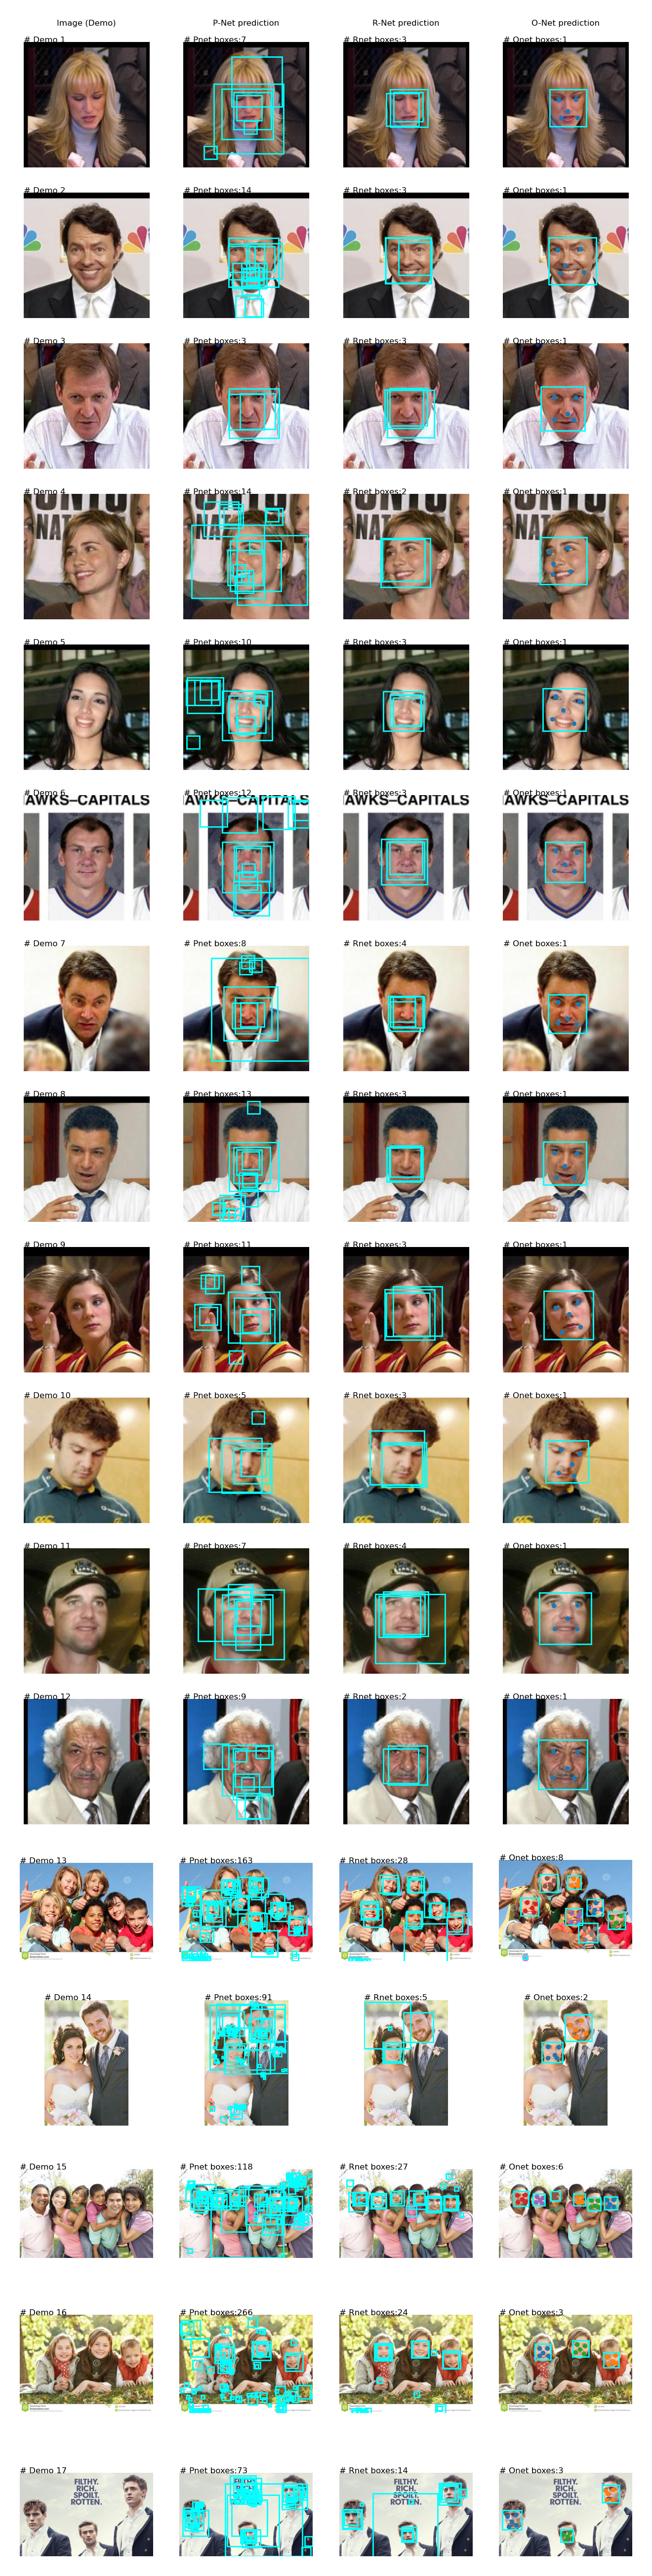

In [12]:
fig, ax = plt.subplots(len(demo_img_path),4,dpi = 400, figsize=(4,len(demo_img_path)))

for i in range(len(demo_img_path)):
    img = Image.open(demo_img_path[i])
    p_bounding_boxes = pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    r_bounding_boxes=rnet_boxes(img, rnet, p_bounding_boxes, show_boxes=False)
    
    if r_bounding_boxes is not None and len(r_bounding_boxes) != 0:
        bounding_boxes = np.vstack((p_bounding_boxes, r_bounding_boxes))
    else:
        bounding_boxes=p_bounding_boxes
        
    try:
        o_bounding_boxes,ldmk=onet_boxes(img, onet,  bounding_boxes)
    except:
        o_bounding_boxes,ldmk=[],[]
    
    ax[i,0].imshow(img)  
    ax[i,0].text(0, 0, '# Demo '+str(i+1),fontsize=3)
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# Pnet boxes:'+str(len(p_bounding_boxes)),fontsize=3)
    for b in p_bounding_boxes[:100]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
    
    ax[i,2].imshow(img)
    ax[i,2].text(0, 0, '# Rnet boxes:'+str(len(r_bounding_boxes)),fontsize=3)
    for b in r_bounding_boxes:
        ax[i,2].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5))   
        
    ax[i,3].imshow(img)
    ax[i,3].text(0, 0, '# Onet boxes:'+str(len(o_bounding_boxes)),fontsize=3)
    for b in o_bounding_boxes:
        ax[i,3].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor = 'cyan',linewidth=0.5)) 
    for l in ldmk:    
        ax[i,3].scatter([l[j*2] for j in range(5)],[l[j*2+1] for j in range(5)],s=0.5)


for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Image (Demo)",fontsize=3)
ax[0][1].set_title("P-Net prediction",fontsize=3)
ax[0][2].set_title("R-Net prediction",fontsize=3)
ax[0][3].set_title("O-Net prediction",fontsize=3)
fig.show()
fig.savefig('demo_Test.png')